In [1]:
# Importing stock libraries
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from transformers import ProphetNetTokenizer, ProphetNetForConditionalGeneration

# Use 0 for t5, 1 for bart and 2 for ProphetNet
choosen_model = 1
data_augmentation = True
conclusion_included = True

from torch import cuda
device = 'cuda:1' if cuda.is_available() else 'cpu'

print(device)

cuda:1


<h4> Define a function to extract abstract, body and conclusion of the articles cointained in the PDF files </h4>

In [5]:
from pdfminer.high_level import extract_text
import re
import os

def extract_articles(pdf_path):
    abstracts = []
    bodies = []
    conclusions = []
    
    for file in os.listdir(pdf_path):
        
        path = os.path.join(pdf_path, file)
        print(path)

        # Estract the text from the PDF file
        pdf_text = extract_text(path)

        # Define a regex to detect the abstract
        pattern = re.compile(r'Abstract\. (.*?)(?=\n\n(?:Keywords|1 Introduction|Introduction))', re.DOTALL| re.IGNORECASE)
        matches = pattern.finditer(pdf_text)
        matches_list = list(matches)
        print("Numero di articoli trovati:", len(matches_list))
        
        for i,match in enumerate(matches_list):
            
            if i<len(matches_list)-1:

                next_article_start = matches_list[i+1].start()
            else:

                next_article_start = -1

            abstract_start = match.start()+ 9 
            abstract_end = match.end()

            body_start = pdf_text.find('Introduction', abstract_end) + 12

            # Define a regex to detect the start of the conclusions
            pattern = re.compile(r'\n\d{1,2}\sConclusion')
            match = pattern.search(pdf_text[body_start: next_article_start]) 
            
            if match:
                body_end = body_start + match.start()
            else:
                body_end = -1            

            # If not explicit conluclion are found there are some other possibilities
            if body_end == -1:
                endings = ['Discussion and Conclusion','Summary','Current Challenges','Result','Evaluation', 'Conclusion']
                for end in endings: 
                    pattern = re.compile(r'\b\d+(\.\d+)?\s' + re.escape(end))
                    alt_match = pattern.search(pdf_text[body_start: next_article_start])
                    
                    if alt_match:
                        body_end = body_start + alt_match.start()
                        print(f"Article {i} instead of Conclusion has {end} as ending")
                        break
                if body_end == -1:
                    print(f"No conclusion found for article {i}")
                    
            else:
                next_line_index = pdf_text.find('\n', body_end+1)
                if next_line_index != -1:
                    body_end = next_line_index

            abstract = pdf_text[abstract_start:abstract_end].strip()
            body = pdf_text[body_start:body_end - 12].strip()

            conclusion_start =pdf_text.find('\n', body_end + 1) 
            conclusion_end = pdf_text.find('References', body_end) 
            conclusion = pdf_text[conclusion_start:conclusion_end].strip()

            conclusions.append(conclusion)
            abstracts.append(abstract)
            bodies.append(body)

      
    return abstracts, bodies, conclusions

<h4>Extract the informations from the files</h4>

In [16]:
pdf_file_path = './Documents' 
abstract_texts, body_texts, conclusion_texts = extract_articles(pdf_file_path)

./Documents/978-3-031-41676-7-Part-I.pdf
Numero di articoli trovati: 31
./Documents/978-3-031-41679-8-Part-II.pdf
Numero di articoli trovati: 36
Article 4 instead of Conclusion has Conclusion as ending
./Documents/978-3-031-41685-9-Part-IV-Handwriting.pdf
Numero di articoli trovati: 28
./Documents/978-3-031-41682-8-Part-III-Document-NLP.pdf
Numero di articoli trovati: 30
./Documents/978-3-031-41734-4-Part-V.pdf
Numero di articoli trovati: 33
Article 11 instead of Conclusion has Summary as ending
Article 20 instead of Conclusion has Discussion and Conclusion as ending
./Documents/978-3-031-41731-3-Scene-Text-Part-VI.pdf
Numero di articoli trovati: 10
./Documents/978-3-031-41498-5-Workshops-I.pdf
Numero di articoli trovati: 22
Article 6 instead of Conclusion has Current Challenges as ending
Article 13 instead of Conclusion has Evaluation as ending
Article 19 instead of Conclusion has Discussion and Conclusion as ending
./Documents/978-3-031-41501-2-Workshops-II.pdf
Numero di articoli tro

<h4>Define a function to clear the gatherated text </h4>

In [17]:
def clean_text(text):
    
    # To discard some common string in the article related to the conference
    text = re.sub(r'c\(cid\:2\) The Author\(s\), under exclusive license to Springer Nature Switzerland AG 2023','',text)
    text = re.sub(r'G\. A\. Fink et al\. \(Eds\.\)\: ICDAR 2023, LNCS \d{5}, pp\. \d{1,4}\–\d{1,4}, 2023\.','',text)
    text = re.sub(r'This work was supported by Grant PID2020\-116813RB\-I00 funded by MCIN\/AEI\/','',text)
    text = re.sub(r'10\.13039\/501100011033\, by Grant ACIF\/2021\/436 funded by Generalitat Valen-','',text)
    text = re.sub(r'ciana and by Grant PID2021\-124719OB\-I00 funded by MCIN\/AEI\/10\.13039\/5011','',text)
    text = re.sub(r'00011033 and by ERDF\, EU A way of making Europe\.','',text)
    text = re.sub(r'A\. Banerjee and S\. Biswas\—These authors contributed equally to this work\.','',text)
    text = re.sub(r'Md\. I\. H\. Shihab\, Md\. R\. Hasan\, M\. R\. Emon\, A\. I\. Humayun and A\. Sushmit\—Equal\ncontribution\.','',text)
    text = re.sub(r'BaDLAD\: A Large Multi\-Domain Bengali Document Layout','',text)
    text = re.sub(r'\nProject website\:','',text)
    text = re.sub(r'L\. He\—Work done while a research intern at Microsoft Cloud and AI\.','',text)
    text = re.sub(r'A\. Scius\-Bertrand et al\.','',text)
    text = re.sub(r'Z. Yang\, X\. Song and S\. Song\—Equal Contribution\.','',text)
    text = re.sub(r'\n\n.*?\n\n\d+\n', '', text)
    
    text = re.sub(r'c\(cid\:2\)', '', text)
    text = re.sub(r'\(cid\:2\)', '', text)

    # To discard the page number
    text = re.sub(r'\d{1,4}\s\n','',text) 
    text = re.sub(r'\n\d+\.\d+\n','\n',text) 
    
    # To discard the figure reference
    text = re.sub(r'\n\nFig\.\s\d+\..*?\n\n', '\n', text, flags=re.DOTALL)

    # To discard citations
    text = re.sub(r'\s*\[\d+(,\s*\d+)*\]','',text)
    text = re.sub(r'\s*\[\d{1,2}\–\d{1,2}\]','',text)
    text = re.sub(r'\s*\[\d{1,2},\d{1,2}\–\d{1,2}\]','',text)
    text = re.sub(r'\n\x0c[^\n]*\n','',text)
    text = re.sub(r'\n[A-Za-z]\.\s\w+\s+et al\.','',text)
    text = re.sub(r'\n\d{1,2}\s(?=\w).*', '\n', text)

    text = re.sub(r'\n\n','\n',text)
    text = re.sub(r'\n\d{1,2}\n','\n',text)


    text = text.lower()

    # To discard URLs
    text = re.sub(r'https?://[^\s]+', '', text)  # Rimuove URL

    # To merge a sentence that was splitted in two seperated rows
    text=re.sub(r'(\w+)\s*-\s*\n\s*(\w+)', r'\1\2', text)

    text = re.sub(r'\n',' ',text)

    # To discard extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'^\s*$', '', text, flags=re.MULTILINE)

    return text

<h4>Clean the gathered texts and create a DataFrame</h4>

In [ ]:
cleaned_data = []
for abstract, body, conclusion in zip(abstract_texts,body_texts, conclusion_texts):

  article_abstract = "".join(clean_text(abstract))
  article_body = "".join(clean_text(body))
  article_conclusion = "".join(clean_text(conclusion))
  
  cleaned_data.append([article_abstract, article_body, article_conclusion])

df = pd.DataFrame(cleaned_data, columns=['article_abstract','article_body' ,'article_conclusion'])
df.head()

<h4>Store the cleaned texts, in order to avoid repeating the process every time</h4>

In [22]:
with open('cleaned_data.pkl', 'wb') as f:
    pickle.dump(cleaned_data, f)

<h4>Load the data and create a DataFrame</h4>

In [2]:
# Load pre-processed data
with open('cleaned_data.pkl', 'rb') as f:
    cleaned_data = pickle.load(f)

# Convert loaded data into DataFrame
df = pd.DataFrame(cleaned_data, columns=['article_abstract','article_body', 'article_conclusion'])    
df.head()

,article_abstract,article_body,article_conclusion
0,the rey-osterrieth complex figure test (rocft)...,the rey-osterrieth complex figure test (rocft)...,"in this work, we developed and validated an ap..."
1,accurately extracting structured data from str...,"as typical rich-format business documents, ﬁna...","in this paper, we proposed a new method for st..."
2,state-of-the-art oﬄine optical character recog...,semi-structured documents are widely used in m...,"in this work, we (i) developed the ﬁrst datase..."
3,document binarization plays a key role in info...,document binarization refers to the process of...,"in this paper, we have proposed a new binariza..."
4,we present a novel sub-stroke level transforme...,"in today’s highly virtual and automated world,...","in this paper, we presented a novel sub-stroke..."


In [182]:
# Get the lenght of each abstracy
abstract_lengths = df['article_abstract'].apply(lambda x: len(x.split()))

# Look for the max
max_abstract_length = abstract_lengths.max()
print("Max abstract lenght:", max_abstract_length)

Max abstract lenght: 274


<h4> Split the dataset and create train, validation and test sets </h4>

In [3]:
import random

train_test_split = 0.9 # 90% of the data is used for training and and 10% for testing
train_val_split = 0.89

# Set a seed for the random split to let the experiment replicable
seed = 10 # or random.randint(0, 100)

# Split the dataset in train/val and test sets
train_val_dataset = df.sample(frac = train_test_split, random_state = seed)
test_dataset = df.drop(train_val_dataset.index)

# Split train and val set
train_dataset = train_val_dataset.sample(frac = train_val_split, random_state = seed)
val_dataset = train_val_dataset.drop(train_dataset.index)

train_dataset = train_dataset.reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

print("Full dataset size: {}".format(df.shape))
print("Train dataset size: {}".format(train_dataset.shape))
print("Validation dataset size: {}".format(val_dataset.shape))
print("Test dataset size: {}".format(test_dataset.shape))

Full dataset size: (211, 3)
Train dataset size: (169, 3)
Validation dataset size: (21, 3)
Test dataset size: (21, 3)


<h4>Implement some Data Augmentation on the texts </h4>


In [4]:
from nltk.corpus import wordnet, stopwords, words
from gensim.models import KeyedVectors
import nltk
import random
import spacy
import string

# Inizializza NLTK e spaCy
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('words')

stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
word_list = set(words.words())

# Load Word2Vec
W2V_path = '/data01/dm23mattri/GoogleNews-vectors-negative300.bin'
W2V = KeyedVectors.load_word2vec_format(W2V_path, binary = True)

[nltk_data] Downloading package wordnet to
[nltk_data]     /data01/dm23mattri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /data01/dm23mattri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /data01/dm23mattri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /data01/dm23mattri/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /data01/dm23mattri/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [5]:
# Function to shuffle sentences in the text
def permute_sentences(text):
    sentences = nltk.sent_tokenize(text, language = "english")
    original_sentences = sentences.copy()
    while True:
        random.shuffle(sentences)
        if sentences != original_sentences:
            break
    return ' '.join(sentences)

def get_synonyms_word2vec(word):
    synonyms = set()
    similar_words = W2V.most_similar(word)
    for syn in similar_words:
            synonym = syn[0]
            synonym = synonym.replace('_', ' ').lower()
            if synonym != word:  
                synonyms.add(synonym)
    return list(synonyms)

def get_synonyms_wordnet(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym != word:  
                synonyms.add(synonym)
    return list(synonyms)

def augment_text_synonims(text, prob = 0.8):
    words = nltk.word_tokenize(text, language = "english")
    augmented_text = []
    for word in words:

        if word.lower() not in stop_words and word not in string.punctuation:
            
            if random.random() < prob:
                synonyms = get_synonyms_wordnet(word)
                #if word in W2V.key_to_index:
                #    synonyms = get_synonyms_word2vec(word)
                if synonyms:
                    word = random.choice(synonyms)

        augmented_text.append(word)
    return ' '.join(augmented_text)

def random_insertion_deletion(text, prob = 0.1):
    words = nltk.word_tokenize(text, language = "english")
    augmented_text = []
    for word in words:
        if word.lower() not in stop_words and word not in string.punctuation:
            if random.random() < prob:
                augmented_text.append(random.choice(list(word_list)))
            if random.random() > prob:
                augmented_text.append(word)
        else:
            augmented_text.append(word)

    return ' '.join(augmented_text)

In [6]:
from tqdm import tqdm
augmented_data = []

for index, row in tqdm(train_dataset.iterrows(), total=train_dataset.shape[0]):
    
    if data_augmentation:

        # Extract a row from the dataframe
        original_abstract = row['article_abstract']
        original_body = row['article_body']
        original_conclusion = row['article_conclusion']

        # Apply data augmentation
        augmented_body_synonym = augment_text_synonims(original_body) 
        augmented_body_permuted = permute_sentences(original_body)
        augmented_body_insert_delete = random_insertion_deletion(original_body)

        if conclusion_included:
            augmented_conclusion_synonym = augment_text_synonims(original_conclusion)
            augmented_conclusion_permuted = permute_sentences(original_conclusion)
            augmented_conclusion_insert_delete = random_insertion_deletion(original_conclusion)
        else:
            augmented_conclusion_synonym = original_conclusion
            augmented_conclusion_permuted = original_conclusion
            augmented_conclusion_insert_delete = original_conclusion

        # Append the augmented data as a dict
        augmented_data.append({'article_abstract': original_abstract,'article_body': augmented_body_synonym, 'article_conclusion': augmented_conclusion_synonym})
        augmented_data.append({'article_abstract': original_abstract,'article_body': augmented_body_permuted, 'article_conclusion': augmented_conclusion_permuted})
        augmented_data.append({'article_abstract': original_abstract,'article_body': augmented_body_insert_delete, 'article_conclusion': augmented_conclusion_insert_delete})

# Convert the list to a df
df_augmented = pd.DataFrame(augmented_data)

# Combine the two dfs
df_combined = pd.concat([train_dataset, df_augmented], ignore_index=True)

print("Lenght of the new training set :", len(df_combined))

df_combined.head()

100%|██████████| 169/169 [04:45<00:00,  1.69s/it]

Lenght of the new training set : 676


,article_abstract,article_body,article_conclusion
0,as text generative models can give increasingl...,with the growing usage of tablets and styluses...,we have presented three improvements to encode...
1,text-vqa refers to the set of problems that re...,text-vqa plays an integral role in the automat...,the paper presents a new approach to scene tex...
2,constructing a highly accurate handwritten ocr...,"in recent years, researchers in handwritten op...","in this paper, we investigate gc-ddpm to gener..."
3,employing a dictionary can eﬃciently rectify t...,deep learning-based scene text recognition has...,"in this paper, we propose a new dictionary-gui..."
4,multi-document summarization (mds) refers to t...,"in this era of big data, the fast increase of ...","in this paper, we proposed a new unsupervised ..."


<h4> Choose the tokenizer </h4>

In [7]:
if choosen_model == 0:
   tokenizer = T5Tokenizer.from_pretrained("t5-base", legacy = False)
   print("T5 tokenizer loaded")
elif choosen_model== 1:
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
    print("BART tokenizer loaded")
elif choosen_model == 2:
    tokenizer = ProphetNetTokenizer.from_pretrained('microsoft/prophetnet-large-uncased')
    print("ProphetNet tokenizer loaded")
else:
    raise TypeError("Error: wrong number has been use. Use 1,2 or 3 to select the model")

BART tokenizer loaded


<h4>Define the training parameters</h4>

In [8]:
TEXT_MAX_LEN = 512 # Length of the texts passed as input to the model
SUMMARY_MAX_LEN = 275 # Lenghts of the summary generated by the model

TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1

EPOCHS = 20

<h4> Prepare the dataset to be used for training </h4>

In [9]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_max_len, summary_max_len, conclusions = False):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_max_len = source_max_len
        self.summary_max_len = summary_max_len
        self.article_abstract = self.data.article_abstract
        self.article_body = self.data.article_body
        self.article_conclusion = self.data.article_conclusion
        self.included_conclusions = conclusions

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        article_abstract = str(self.article_abstract[index])
        article_abstract = ' '.join(article_abstract.split())

        article_body = str(self.article_body[index])
        article_body = ' '.join(article_body.split())

        if choosen_model == 0:
          article_body = 'summarize: ' + article_body

        article_conclusion = self.article_conclusion[index]
        article_conclusion = ' '.join(article_conclusion.split())

        if self.included_conclusions:

            # Tokenize body and coclusions
            tokenized_body = self.tokenizer.encode_plus(article_body, max_length = self.source_max_len, truncation = True, padding = 'max_length', return_tensors = 'pt')
            tokenized_conclusion = self.tokenizer.encode_plus(article_conclusion, max_length = self.source_max_len, truncation = True, padding = 'max_length', return_tensors = 'pt')

            # Combine the first 256 token of the two sets and the respective attention masks
            combined_input_ids = torch.cat([tokenized_body['input_ids'][:, :256], tokenized_conclusion['input_ids'][:, :256]], dim = 1)
            combined_attention_mask = torch.cat([tokenized_body['attention_mask'][:, :256], tokenized_conclusion['attention_mask'][:, :256]], dim = 1)

            # Produce the new source and target items
            source = {"input_ids": combined_input_ids, "attention_mask": combined_attention_mask}
            target = self.tokenizer.batch_encode_plus([article_abstract], max_length = self.summary_max_len, truncation = True, padding = 'max_length', return_tensors = 'pt')
        else:
            source = self.tokenizer.batch_encode_plus([article_body], max_length = self.source_max_len, padding = 'max_length', truncation = True, return_tensors = 'pt') 
            target = self.tokenizer.batch_encode_plus([article_abstract], max_length = self.summary_max_len, padding = 'max_length', truncation = True, return_tensors = 'pt') 
    
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_mask': target_mask.to(dtype=torch.long)
        }

In [10]:
training_set = CustomDataset(df_combined, tokenizer, TEXT_MAX_LEN, SUMMARY_MAX_LEN, conclusions = True)
validation_set = CustomDataset(val_dataset, tokenizer, TEXT_MAX_LEN, SUMMARY_MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, TEXT_MAX_LEN, SUMMARY_MAX_LEN)

In [11]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
              'shuffle': False,
              'num_workers': 0,
             }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
testing_loader = DataLoader(testing_set, **test_params)

<h4> Check the configuration of the model to better understand its charateristics </h4>

In [12]:
from transformers import T5Config, ProphetNetConfig ,BartConfig

if choosen_model == 0:
    config = T5Config.from_pretrained("t5-base")
elif choosen_model== 1:
    config = BartConfig.from_pretrained('facebook/bart-base')
elif choosen_model == 2:
    config =  ProphetNetConfig.from_pretrained('microsoft/prophetnet-large-uncased')
    config.use_cache = False
else:
    raise TypeError("Error: wrong number has been use. Use 1,2 or 3 to select the model")

#print(config)

<h4> Eventually edit the model's configuration </h4>

In [ ]:
# Eventually introduce some level of dropout
dropout_prob = 0.2

if choosen_model == 0:
    config.classifier_dropout = dropout_prob
    config.dropout_rate = dropout_prob
    pass
elif choosen_model== 1:
    config.activation_dropout = dropout_prob
    config.attention_dropout = dropout_prob
    #config.encoder_layerdrop = dropout_prob
    #config.decoder_layerdrop = dropout_prob
    config.classif_dropout = dropout_prob
    #config.classifier_dropout = dropout_prob
    config.dropout = dropout_prob
elif choosen_model == 2:
    config.activation_dropout = dropout_prob
    config.attention_dropout = dropout_prob
    config.dropout = dropout_prob
else:
    raise TypeError("Error: wrong number has been use. Use 1,2 or 3 to select the model")
    
#print(config)

<h4> Define function to train and evaluate the model </h4>

In [13]:
import matplotlib.pyplot as plt
import time

def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for  data in val_loader:
            y = data['target_ids'].to(device, dtype = torch.long)
            y_ids = y[:, :-1].contiguous()
            lm_labels = y[:, 1:].clone().detach()
            lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids = y_ids, labels = lm_labels)
            loss = outputs[0]
            
            total_loss += loss.item()
    
    avg_epoch_val_loss = total_loss / len(val_loader)
    
    return avg_epoch_val_loss

def train(model,optimizer, epoch, training_loader, validation_loader):

    start_time = time.time()
    model.train()
    train_loss = 0

    for data in training_loader :
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids = y_ids, labels = lm_labels)
        loss = outputs[0]
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # After an epoch evaluate the validation loss
    val_loss = evaluate(model, validation_loader)

    end_time = time.time()
    epoch_time = end_time - start_time
    avg_epoch_train_loss = train_loss/len(training_loader)
    
    print(f"Epoch {epoch + 1}, Training loss: {avg_epoch_train_loss}, Validation loss: {val_loss}, Time: {epoch_time}, LR: ", optimizer.param_groups[0]["lr"])
    
    return train_loss/ len(training_loader), val_loss


<h4> Use Optuna to find the best hyperparameters to train the model </h4>

In [13]:
import optuna
from tqdm.notebook import tqdm
from collections import deque
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, PolynomialLR,StepLR, LambdaLR

# Define the objective function to optimize
def objective(trial):

    # Define the trails for the hyperparameters to optimize
    lr = trial.suggest_float('lr', 1e-6, 1e-4, log = True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log = True)
    step_size =  trial.suggest_int('step_size', 1, 3)  
    gamma = trial.suggest_float('gamma', 0.5, 0.99)     

    # Define the model
    torch.cuda.empty_cache() 
    if 'model' in locals():
        del model

    if choosen_model == 0:
        model = T5ForConditionalGeneration.from_pretrained("t5-base", config = config)
    elif choosen_model== 1:
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-base', config = config)
    elif choosen_model == 2:
        model = ProphetNetForConditionalGeneration.from_pretrained('microsoft/prophetnet-large-uncased', config = config)
    else:
        print("Error: wrong number has been used. Use 1,2 or 3 to select the model")
    
    model = model.to(device)
        
    # Define the optimizer to train the model
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    scheduler = StepLR(optimizer, step_size = step_size, gamma = gamma)

    val_loss_history = [] 
    count = 0

    # Train the model with early stopping
    for epoch in (range(EPOCHS)):
        train_loss, val_loss = train(model,optimizer, epoch, training_loader, validation_loader)
        val_loss_history.append(val_loss)
        scheduler.step()
        
        if len(val_loss_history) > 1 :
            if val_loss >= val_loss_history[-2] or val_loss > min(val_loss_history):
                count += 1
                if count >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break
            else:
                count = 0
    
    # Use the last value of validation loss as score
    return val_loss_history[-1]

patience = 2

# Create a study using Optune to minimize the validation loss
study = optuna.create_study(direction = 'minimize', study_name = "Hyperparameter Optimization BART")
study.optimize(objective, n_trials = 100, show_progress_bar = True, timeout = 600 * 3)

[I 2024-08-24 18:40:56,025] A new study created in memory with name: no-name-7c540e7c-f49f-4e78-9cf6-5e81e144bd56


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Training loss: 4.527435366218612, Validation loss: 3.6120918705349876, Time: 45.131327867507935, LR:  1.51603258442109e-06
Epoch 2, Training loss: 4.127560200775869, Validation loss: 3.5101857412429083, Time: 44.48086190223694, LR:  1.51603258442109e-06
Epoch 3, Training loss: 4.013584167999629, Validation loss: 3.4502882730393183, Time: 44.59047508239746, LR:  1.1191416425799712e-06
Epoch 4, Training loss: 3.9900497318019528, Validation loss: 3.4154942603338334, Time: 44.627875328063965, LR:  1.1191416425799712e-06
Epoch 5, Training loss: 3.8709760474030084, Validation loss: 3.373841467357817, Time: 41.72936201095581, LR:  8.261550767623279e-07
Epoch 6, Training loss: 3.8579395677916395, Validation loss: 3.346209685007731, Time: 32.453065156936646, LR:  8.261550767623279e-07
Epoch 7, Training loss: 3.8074958945167134, Validation loss: 3.3328864120301747, Time: 32.57496976852417, LR:  6.098711591918945e-07
Epoch 8, Training loss: 3.757411292318762, Validation loss: 3.316330217

In [ ]:
# Print the best hyperparameter setting found using Optuna
print("\n\nBest trial: ")
print("\nValue: ", study.best_trial.value)
print("\nParams: ")

for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

</h4> Train the model with the found hyperparameters </h4>

In [ ]:
from tqdm.notebook import tqdm
import gc
from collections import deque
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, PolynomialLR,StepLR, LambdaLR

#l_rates = []
loss_values = []
val_losses = []
patience = 2
gc.collect()
torch.cuda.empty_cache()  # Rilascio della memoria GPU

# Eliminazione del modello se esiste
if 'model' in locals():
    del model

if choosen_model == 0:
    model = T5ForConditionalGeneration.from_pretrained("t5-base", config = config)
elif choosen_model == 1:
    model = BartForConditionalGeneration.from_pretrained('facebook/bart-base', config = config)
elif choosen_model == 2:
    model = ProphetNetForConditionalGeneration.from_pretrained('microsoft/prophetnet-large-uncased', config = config)
else:
    raise TypeError("Error: wrong number has been used. Use 1,2 or 3 to select the model")

model = model.to(device)
'''
for name, param in model.named_parameters():
        param.requires_grad = False
        if "decoder" in str(name):  
            if "Dense" in str(name): # Freeza tutti i parametri tranne quelli della testa
                param.requires_grad = True
'''

def get_lr_lambda(current_step, warmup_steps, gamma, step_size):
    if current_step < warmup_steps:
        # Linear warmup
        return float(current_step) / float(max(1, warmup_steps))
    else:
        # After warmup, apply StepLR-like behavior
        steps_since_warmup = current_step - warmup_steps
        return gamma ** (steps_since_warmup // step_size)


warmup_steps = 3  # Number of steps to warm up
gamma = 0.6  # Decay rate for StepLR
step_size = 1  # Step size for StepLR

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, weight_decay = 1e-4)

# Create the LambdaLR with warmup and StepLR-like behavior
scheduler = LambdaLR(optimizer, lr_lambda = lambda step: get_lr_lambda(step, warmup_steps, gamma, step_size))
#scheduler = StepLR(optimizer, step_size = step_size, gamma = gamma)  

val_loss_history = []
count = 0
for epoch in tqdm(range(EPOCHS)):
  train_loss, val_loss = train(model, optimizer, epoch, training_loader, validation_loader)
  val_loss_history.append(val_loss)
  val_losses.append(val_loss)
  loss_values.append(train_loss)
  scheduler.step()
  
# Implement some early stopping
  if len(val_loss_history) > 1 :
    if val_loss >= val_loss_history[-2] or val_loss > min(val_loss_history):
        count += 1
        if count >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
    else:
        count = 0

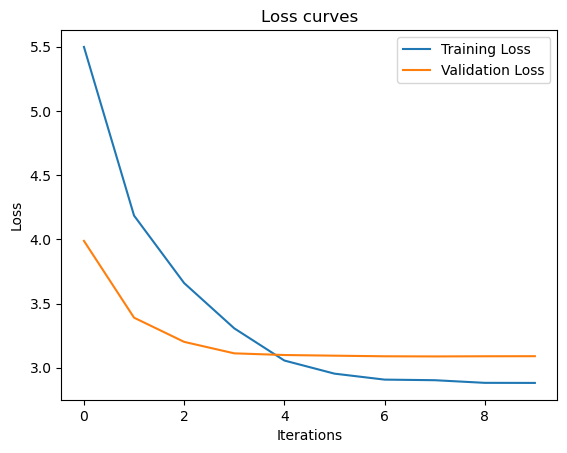

In [15]:
# Plot the loss curves

plt.plot(loss_values, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss curves")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h4> Test the performance of the model generating a summary </h4>

In [16]:
# Select a sample of the training set
sample = testing_set[0]  

input_ids = sample['source_ids'].unsqueeze(0).to(device)
target_ids = sample['target_ids'].unsqueeze(0).to(device)
input_mask = sample['source_mask'].unsqueeze(0).to(device)

# Generate the summary
with torch.no_grad():

    summary_ids = model.generate(input_ids, attention_mask = input_mask,
                                    num_beams = 5,
                                    no_repeat_ngram_size = 3,
                                    min_length = 100,
                                    max_length = 250,
                                    early_stopping = False)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens = True)

print("Testo di input:", tokenizer.decode(input_ids[0], skip_special_tokens = True))
print("Target:", tokenizer.decode(target_ids[0], skip_special_tokens = True))
print("Riassunto generato:", summary)

Testo di input: the rey-osterrieth complex figure test (rocft) was designed to examine the visuospatial ability and memory in patients who suﬀer from traumatic brain injury. additionally, the test is utilized to test for dementia and to evaluate children’s cognitive development. the test procedure starts with presenting the ﬁgure depicted in fig. 1 to the patient, who is subsequently asked to copy it by drawing it, typically with a pen on paper. after 3 min, the patient is asked to reproduce the ﬁgure from memory. this procedure is repeated after 30 min. b. schuster et al. those three steps are called copy, immediate recall, and delayed recall. while copy is always part of the procedure, sometimes only one of the steps immediate recall or delayed recall are carried out. the ﬁgure can be subdivided into 18 separate sections, as annotated in fig. 1. according to the osterrieth scoring system, for each section, a score ranging from 0 to 2 is determined in the following way: if the unit is

<h4> Compute the ROUGE score for the trained model </h4>

In [18]:
from rouge_score import rouge_scorer

def compute_rouge_score(model, test_set, tokenizer):

    rouge_scores = []
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer = True)
    
    for i in range(len(test_set)):

        sample = test_set[i]
        input_ids = sample['source_ids'].unsqueeze(0).to(device)
        target_ids = sample['target_ids'].unsqueeze(0).to(device)
        input_mask = sample['source_mask'].unsqueeze(0).to(device)

        # Generate the summary
        with torch.no_grad():
            summary_ids = model.generate(input_ids, attention_mask=input_mask,
                                        num_beams = 5,
                                        no_repeat_ngram_size = 2,
                                        min_length = 100,
                                        max_length = 250,
                                        early_stopping = False)

        summary = tokenizer.decode(summary_ids[0], skip_special_tokens = True)

        # Compute the rouge score between the abstract and the generated summary
        target_summary = tokenizer.decode(target_ids[0], skip_special_tokens = True)
        rouge_score = rouge.score(target_summary, summary)

        rouge_scores.append(rouge_score)

    # Compute the average rouge score
    rouge_1_avg = sum(score['rouge1'].fmeasure for score in rouge_scores) / len(rouge_scores)
    rouge_2_avg = sum(score['rouge2'].fmeasure for score in rouge_scores) / len(rouge_scores)
    rouge_L_avg = sum(score['rougeL'].fmeasure for score in rouge_scores) / len(rouge_scores)

    print(f'ROUGE-1 Avg F1: {rouge_1_avg}')
    print(f'ROUGE-2 Avg F1: {rouge_2_avg}')
    print(f'ROUGE-L Avg F1: {rouge_L_avg}')

compute_rouge_score(model, testing_set, tokenizer)

ROUGE-1 Avg F1: 0.43972721828138245
ROUGE-2 Avg F1: 0.1332763230065144
ROUGE-L Avg F1: 0.22396936036696274


<h4> Compute the n-gram novelty of the trained model </h4>

In [19]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_ngram_novelty(reference, generated, n):
    reference_tokens = reference.split()
    generated_tokens = generated.split()

    weights = (0,0,0,0)
    weights1 = tuple(weights[:n-1] + (1,) + weights[n:])

    # Compute the blue score
    bleu_score = sentence_bleu([reference_tokens], generated_tokens, weights = weights1,  smoothing_function = SmoothingFunction().method1)

    # Compute the n-gram novelty
    novelty = 1 - bleu_score

    return novelty

def compute_novelty(model, test_set, tokenizer):
    novelty_scores_input = [[] for _ in range(3)] 
    novelty_scores_target = [[] for _ in range(3)]  

    for i in range(len(test_set)):
        sample = test_set[i]
        input_ids = sample['source_ids'].unsqueeze(0).to(device)
        input_mask = sample['source_mask'].unsqueeze(0).to(device)
        target_summary = tokenizer.decode(sample['target_ids'], skip_special_tokens = True)
        input_text = tokenizer.decode(sample['source_ids'], skip_special_tokens = True)

        with torch.no_grad():
            summary_ids = model.generate(input_ids, attention_mask = input_mask,
                                        num_beams = 5,
                                        no_repeat_ngram_size = 2,
                                        min_length = 100,
                                        max_length = 250,
                                        early_stopping = False)

        generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens = True)

        for i in range(3):  
            #novelty_score_input = compute_ngram_novelty(input_text, generated_summary, n = i+1)
            #novelty_scores_input[i].append(novelty_score_input)

            novelty_score_target = compute_ngram_novelty(target_summary, generated_summary, n = i+1)
            novelty_scores_target[i].append(novelty_score_target)


    for i in range(3): 

        #novelty_avg_input = sum(novelty_scores_input[i]) / len(novelty_scores_input[i])
        novelty_avg_target = sum(novelty_scores_target[i]) / len(novelty_scores_target[i])

        #print(f'Average Novelty Score for n={i+1} (Input): {novelty_avg_input}')
        print(f'Average Novelty Score for n={i+1} (Target): {novelty_avg_target}')


compute_novelty(model, testing_set, tokenizer)

Average Novelty Score for n=1 (Target): 0.6841917098603981
Average Novelty Score for n=2 (Target): 0.9176483085623549
Average Novelty Score for n=3 (Target): 0.968106989180785


<h4> Save the model if it was good </h4>

In [ ]:
model_dir = f"pytorch_models"
model_name = "BART"  
model_path = f"{model_dir}/{model_name}.pt"

torch.save(model, model_path)

<h4> Eventually load some fine-tuned model </h4>

In [ ]:
model_dir = f"pytorch_models"
model_name = "BART"
model_path = f"{model_dir}/{model_name}.pt"

model = torch.load(model_path)